In [22]:
! pip install polars pyarrow yfinance joblib pandas numpy matplotlib seaborn scikit-learn


   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   ------------------- -------------------- 5.2/10.7 MB 26.5 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 30.4 MB/s eta 0:00:00

   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   ------------- -------------------------- 1/3 [scikit-learn]
   -------------

In [1]:
# Add the folder with your calibration .py files to the Python path
import sys
sys.path.append(r'C:\Users\kevin\OneDrive\Desktop\Draco\Summer-Quant-2025\heston calibration\tools')

In [44]:
# Polars version of filtering & enriching SPXW options data

import polars as pl
import os
import shutil
import stat
import pandas as pd
import yfinance as yf
from pathlib import Path

# 0) Make it a directory, not a “.parquet” file
INPUT_PATTERN = r"C:\Users\kevin\OneDrive\Desktop\Draco\spxw_filtered\*.csv"
OUTPUT_DIR    = Path(r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_pre_filtered_parquet")

# Clean up any old output directory
def on_rm_error(func, path, exc_info):
    os.chmod(path, stat.S_IWRITE)
    func(path)

if OUTPUT_DIR.exists():
    shutil.rmtree(OUTPUT_DIR, onerror=on_rm_error)

# 1. Get min_date, max_date from your options LazyFrame
lf = pl.scan_csv(
    INPUT_PATTERN,
    dtypes={
        "ticker": pl.Utf8, "volume":pl.Int64, "open":pl.Float64,
        "close":pl.Float64, "high":pl.Float64, "low":pl.Float64,
        "window_start":pl.Int64, "transactions":pl.Int64
    }
).filter(pl.col("window_start").is_not_null() & (pl.col("window_start") > 0))

# Parse ticker and derive date columns for min/max date
pat = r"O:SPXW(\d{6})([CP])(\d{8})"
lf_dates = (
    lf.with_columns([
        pl.col("ticker").str.extract(pat, 1).str.strptime(pl.Date, "%y%m%d", strict=False).alias("expiration"),
        pl.col("window_start").cast(pl.Datetime("ns")).dt.date().alias("date")
    ])
    .filter(pl.col("expiration").is_not_null() & pl.col("date").is_not_null())
)
date_bounds = lf_dates.select([
    pl.col("date").min().alias("min"),
    pl.col("date").max().alias("max")
]).collect()
min_date, max_date = date_bounds["min"][0], date_bounds["max"][0]

# 2. Build a complete date range as a DataFrame
all_dates = pd.DataFrame({"date": pd.date_range(min_date, max_date, freq="D").date})

# 3. Fetch SPX and IRX, merge with all_dates, and forward-fill
spx_pd = (yf.Ticker("^GSPC")
           .history(start=min_date, end=max_date + pd.Timedelta(days=1))
           ["Close"].reset_index().rename(columns={"Close":"S"}))
spx_pd["date"] = spx_pd["Date"].dt.date
spx_pd = all_dates.merge(spx_pd[["date", "S"]], on="date", how="left").fillna(method="ffill")
spx = pl.from_pandas(spx_pd[["date", "S"]])

irx_pd = (yf.Ticker("^IRX")
           .history(start=min_date, end=max_date + pd.Timedelta(days=1))
           ["Close"].reset_index().rename(columns={"Close":"r"}))
irx_pd["date"] = irx_pd["Date"].dt.date
irx_pd["r"] = irx_pd["r"] / 100.0
irx_pd = all_dates.merge(irx_pd[["date", "r"]], on="date", how="left").fillna(method="ffill")
irx = pl.from_pandas(irx_pd[["date", "r"]])

spx_lazy = spx.lazy()
irx_lazy = irx.lazy()

# 4. Build the full LazyFrame pipeline
# previous steps up to joining S & r
lf = (
    pl.scan_csv(INPUT_PATTERN, dtypes={ 
        # specify your dtypes here, e.g.:
        "ticker": pl.Utf8, "volume":pl.Int64, "open":pl.Float64,
        "close":pl.Float64, "high":pl.Float64, "low":pl.Float64,
        "window_start":pl.Int64, "transactions":pl.Int64
    })
      .filter(pl.col("window_start") > 0)
      .with_columns([
         pl.col("ticker").str.extract(pat, 2).replace({"C":"call","P":"put"}).alias("option_type"),
         pl.col("ticker").str.extract(pat, 1).str.strptime(pl.Date,"%y%m%d",strict=False).alias("expiration"),
         pl.col("ticker").str.extract(pat, 3).cast(pl.Int64).alias("strike_raw"),
         pl.col("window_start").cast(pl.Datetime("ns")).dt.date().alias("date")
      ])
      .filter(
         pl.col("expiration").is_not_null() &
         pl.col("strike_raw").is_not_null() &
         pl.col("date").is_not_null()
      )
      .with_columns([
         (pl.col("strike_raw")/1_000).alias("strike"),
         ((pl.col("expiration").cast(pl.Datetime("ns")) -
           pl.col("date"      ).cast(pl.Datetime("ns")))
          .dt.total_days()/365.0).alias("T")
      ])
      # your T and price filters
      .filter((pl.col("T")>7/365)&(pl.col("T")<180/365)&(pl.col("close")>0.1))
      # filter out very low volume options
      .filter(pl.col("volume") >= 5)
      # join in S & r
      .join(spx_lazy, on="date", how="left")
      .join(irx_lazy, on="date", how="left")

      # put–call parity / OTM filter
      .with_columns([
        # forward price F = S * exp(r * T)
        (pl.col("S") * (pl.col("r") * pl.col("T")).exp()).alias("F")
      ])
      .filter(
         ((pl.col("option_type")=="call") & (pl.col("strike") >= pl.col("F")))
       | ((pl.col("option_type")=="put")  & (pl.col("strike") <= pl.col("F")))
      )
      .drop("F")

      # now select your final columns
      .select(["date","strike","T","close","option_type","S","r"])
)

# 5. Collect to eager DataFrame
df = lf.collect()

# 6. Write out partitioned Parquet directory by date
df.write_parquet(
    OUTPUT_DIR,
    compression="snappy",
    partition_by="date"
)

print("🎉 Pre-filtered & date-partitioned Parquet written to", OUTPUT_DIR)


C:\Users\kevin\AppData\Local\Temp\ipykernel_9544\4198447193.py:24: DeprecationWarning: the argument `dtypes` for `scan_csv` is deprecated. It was renamed to `schema_overrides` in version 0.20.31.
  lf = pl.scan_csv(
C:\Users\kevin\AppData\Local\Temp\ipykernel_9544\4198447193.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  spx_pd = all_dates.merge(spx_pd[["date", "S"]], on="date", how="left").fillna(method="ffill")
C:\Users\kevin\AppData\Local\Temp\ipykernel_9544\4198447193.py:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  irx_pd = all_dates.merge(irx_pd[["date", "r"]], on="date", how="left").fillna(method="ffill")
C:\Users\kevin\AppData\Local\Temp\ipykernel_9544\4198447193.py:73: DeprecationWarning: the argument `dtypes` for `scan_csv` is deprecated. It was renamed to `schema_overrides` in version

🎉 Pre-filtered & date-partitioned Parquet written to C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_pre_filtered_parquet


In [45]:
# Read  sampled options data and save to CSV for inspection

import polars as pl
import pandas as pd
import os

SAMPLED_PARQUET_DIR = r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_sampled_parquet"

# List all date partitions
partitions = [d for d in os.listdir(SAMPLED_PARQUET_DIR) if os.path.isdir(os.path.join(SAMPLED_PARQUET_DIR, d))]
partitions.sort()
first_date = partitions[0]
print("First date partition:", first_date)

# Read all Parquet files for the first date
parquet_files = [os.path.join(SAMPLED_PARQUET_DIR, first_date, f)
                 for f in os.listdir(os.path.join(SAMPLED_PARQUET_DIR, first_date))
                 if f.endswith(".parquet")]

df_first = pl.read_parquet(parquet_files)
print("Shape:", df_first.shape)
print(df_first)

# Save to CSV for inspection
csv_path = f"sampled_options_{first_date}.csv"
df_first.write_csv(csv_path)
print(f"Saved first date's sampled options to {csv_path}")


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\kevin\\OneDrive\\Desktop\\Draco\\data\\spxw_sampled_parquet'

In [49]:
import numpy as np
import pandas as pd
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from py_vollib_vectorized import vectorized_implied_volatility as calculate_iv

def hybrid_kmeans_pca_atm(
    df: pd.DataFrame,
    n_clusters: int = 200,
    n_pca_extremes: int = 0,
    atm_width: float = 0.05,
    atm_frac: float = 0.20,
    num_m_bins: int = 10,             # ← new: how many moneyness bins to enforce
    random_state: int = 42
) -> pd.DataFrame:
    df = df.copy()
    # 1) days & moneyness
    df['days']      = (df['T'] * 365).round().astype(int)
    S, r            = df['S'].iloc[0], df['r'].iloc[0]
    q               = df.get('q', 0.0)
    df['moneyness'] = df['strike'] / S

    # 2) implied‐vol + vega
    flags = np.where(df['option_type']=='call','c','p')
    iv = calculate_iv(
        df['close'].values, S, df['strike'].values, df['T'].values,
        r, flags, q, model='black_scholes_merton', return_as='numpy'
    )/100.0
    iv = np.nan_to_num(iv, nan=1e-6)
    sqrtT = np.sqrt(df['T'])
    d1    = (
        np.log(S/df['strike']) +
        (r - q + 0.5*iv**2)*df['T']
    )/(iv*sqrtT + 1e-12)
    df['vega'] = S * np.exp(-q*df['T']) * sqrtT * np.exp(-0.5*d1**2)/np.sqrt(2*np.pi)

    # 3) quantile‐transform moneyness & normalize days
    max_days     = df['days'].max() or 1
    df['m_rank'] = df['moneyness'].rank(pct=True)
    df['d_norm'] = df['days'] / max_days

    # 4) KMeans → pick max‐vega per cluster
    X  = np.vstack([df['m_rank'], df['d_norm']]).T
    km = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
    df['cluster'] = km.fit_predict(X)
    idx_k        = df.groupby('cluster')['vega'].idxmax().values
    samp_k       = df.loc[idx_k]

    # 5) PCA extremes (optional)
    if n_pca_extremes > 0:
        pca     = PCA(n_components=1, random_state=random_state)
        df['pc1'] = pca.fit_transform(X).ravel()
        half     = n_pca_extremes//2
        samp_pc  = pd.concat([
            df.nlargest(half, 'pc1'),
            df.nsmallest(half, 'pc1')
        ])
    else:
        samp_pc = df.head(0)

    # 6) combine & dedupe
    combined = pd.concat([samp_k, samp_pc]) \
                 .drop_duplicates(subset=['strike','T','option_type'])

    # 7) enforce ATM quota
    total_target = n_clusters + n_pca_extremes
    atm_target   = int(atm_frac * total_target)
    in_atm       = combined[np.abs(combined['moneyness']-1) <= atm_width]
    if len(in_atm) < atm_target:
        need   = atm_target - len(in_atm)
        extras = (df[np.abs(df['moneyness']-1) <= atm_width]
                  .drop(combined.index, errors='ignore')
                  .nlargest(need, 'vega'))
        combined = pd.concat([combined, extras])

    # 8) **new**: enforce at least one per m‐bin
    # build m‐bin edges in rank‐space
    edges = np.linspace(0, 1, num_m_bins+1)
    for i in range(num_m_bins):
        lo, hi = edges[i], edges[i+1]
        # does combined have a pick in [lo,hi)?
        mask_comb = combined['moneyness'].rank(pct=True).between(lo, hi, inclusive='left')
        if not mask_comb.any():
            # pick the highest-vega in df for that slice
            mask_df   = df['m_rank'].between(lo, hi, inclusive='left')
            if mask_df.any():
                pick = df[mask_df].nlargest(1, 'vega')
                combined = pd.concat([combined, pick])

    # 9) fill to total_target by vega
    if len(combined) < total_target:
        need      = total_target - len(combined)
        leftovers = df.drop(combined.index, errors='ignore')
        extra     = leftovers.nlargest(need, 'vega')
        combined  = pd.concat([combined, extra])

    # 10) cleanup
    to_drop = ['days','moneyness','m_rank','d_norm','vega','cluster','pc1']
    return combined.drop(columns=[c for c in to_drop if c in combined.columns]) \
                   .reset_index(drop=True)


# ------------------------------------------------------------------------------
# 2) Parallelize and write per-date
# ------------------------------------------------------------------------------
PRE_FILTERED_DIR = Path(r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_pre_filtered_parquet")
OUTPUT_DIR       = Path(r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_sampled_hybrid_parquet")

# Cleanup existing output
def _on_rm_error(func, path, exc_info):
    os.chmod(path, stat.S_IWRITE)
    func(path)

if OUTPUT_DIR.exists():
    shutil.rmtree(OUTPUT_DIR, onerror=_on_rm_error)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def process_date(part_dir: Path):
    df = pl.read_parquet(str(part_dir/"0.parquet")).to_pandas()
    sampled = hybrid_kmeans_pca_atm(df)
    sampled['date'] = part_dir.name.split('=')[1]
    out_dir = OUTPUT_DIR / part_dir.name
    out_dir.mkdir(parents=True, exist_ok=True)
    pl.from_pandas(sampled).write_parquet(str(out_dir/"0.parquet"), compression='snappy')
    return len(sampled)

# Run in parallel
date_dirs = sorted(PRE_FILTERED_DIR.glob("date=*"))
sizes = Parallel(n_jobs=-1, verbose=5)(delayed(process_date)(d) for d in date_dirs)

print("✅ Hybrid KMeans+PCA+ATM sampling done!")
print("Total picks:", sum(sizes))
print("Sample sizes (first 5):", sizes[:5])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    2.4s


✅ Hybrid KMeans+PCA+ATM sampling done!
Total picks: 73400
Sample sizes (first 5): [200, 200, 200, 200, 200]


[Parallel(n_jobs=-1)]: Done 336 out of 367 | elapsed:    3.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 367 out of 367 | elapsed:    3.5s finished


Sampled partitions: ['date=2025-01-13', 'date=2024-08-20', 'date=2024-12-18', 'date=2024-02-14', 'date=2025-02-06', 'date=2024-03-04', 'date=2024-09-25', 'date=2024-05-01', 'date=2024-06-14', 'date=2024-01-16']

Partition: date=2025-01-13
Sampled shape: (200, 7) Full shape: (2563, 7)
         date  strike         T   close option_type            S        r
0  2025-01-13  5800.0  0.164384  126.97         put  5836.220215  0.04218
1  2025-01-13  4400.0  0.076712    3.00         put  5836.220215  0.04218
2  2025-01-13  6060.0  0.068493   16.50        call  5836.220215  0.04218
3  2025-01-13  4900.0  0.460274   60.00         put  5836.220215  0.04218
4  2025-01-13  5825.0  0.027397   57.00         put  5836.220215  0.04218


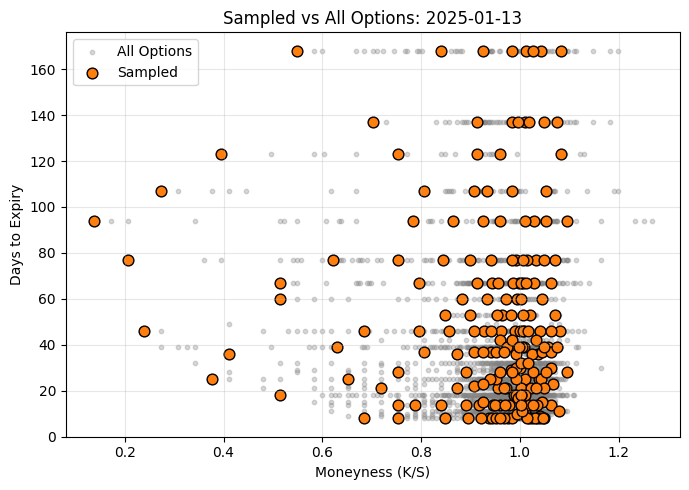


Partition: date=2024-08-20
Sampled shape: (200, 7) Full shape: (2203, 7)
         date  strike         T  close option_type            S        r
0  2024-08-20  2200.0  0.410959   2.30         put  5597.120117  0.05033
1  2024-08-20  5350.0  0.021918   2.45         put  5597.120117  0.05033
2  2024-08-20  5670.0  0.065753  43.95        call  5597.120117  0.05033
3  2024-08-20  4600.0  0.098630   4.00         put  5597.120117  0.05033
4  2024-08-20  5300.0  0.063014  12.05         put  5597.120117  0.05033


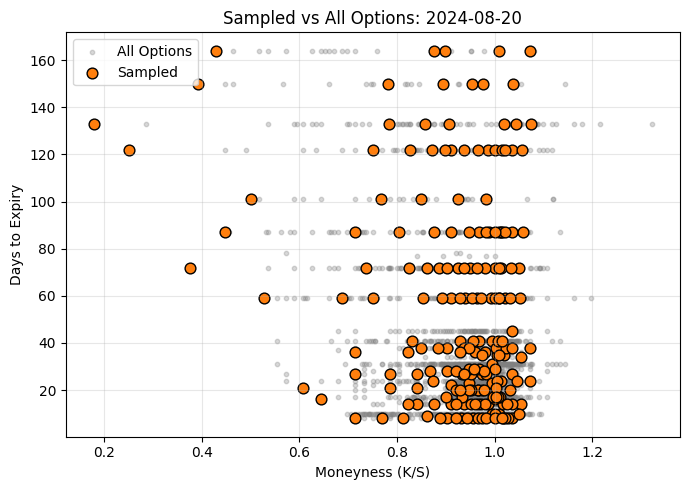


Partition: date=2024-12-18
Sampled shape: (200, 7) Full shape: (3102, 7)
         date  strike         T  close option_type            S        r
0  2024-12-18  6175.0  0.071233   9.10        call  5872.160156  0.04232
1  2024-12-18  4600.0  0.071233   3.20         put  5872.160156  0.04232
2  2024-12-18  5700.0  0.134247  70.41         put  5872.160156  0.04232
3  2024-12-18  4925.0  0.254795  32.46         put  5872.160156  0.04232
4  2024-12-18  5885.0  0.054795  68.10         put  5872.160156  0.04232


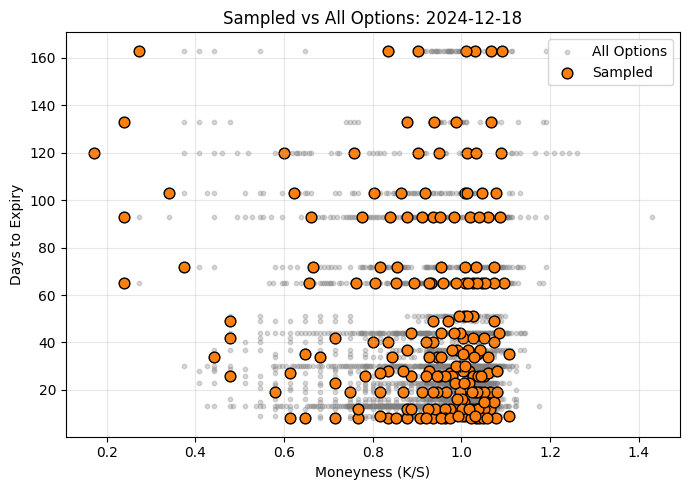


Partition: date=2024-02-14
Sampled shape: (200, 7) Full shape: (2457, 7)
         date  strike         T  close option_type            S        r
0  2024-02-14  5050.0  0.021918  12.70        call  5000.620117  0.05218
1  2024-02-14  4600.0  0.032877   1.75         put  5000.620117  0.05218
2  2024-02-14  4485.0  0.208219  19.80         put  5000.620117  0.05218
3  2024-02-14  4975.0  0.178082  87.99         put  5000.620117  0.05218
4  2024-02-14  4820.0  0.032877   4.41         put  5000.620117  0.05218


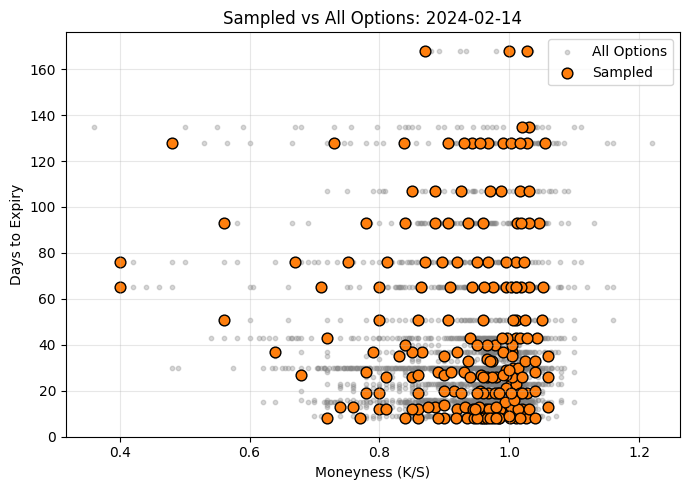


Partition: date=2025-02-06
Sampled shape: (200, 7) Full shape: (2070, 7)
         date  strike         T   close option_type            S        r
0  2025-02-06  6175.0  0.090411   47.90        call  6083.569824  0.04213
1  2025-02-06  5550.0  0.087671    9.49         put  6083.569824  0.04213
2  2025-02-06  5075.0  0.309589   26.03         put  6083.569824  0.04213
3  2025-02-06  6050.0  0.309589  141.63         put  6083.569824  0.04213
4  2025-02-06  5915.0  0.032877   12.21         put  6083.569824  0.04213


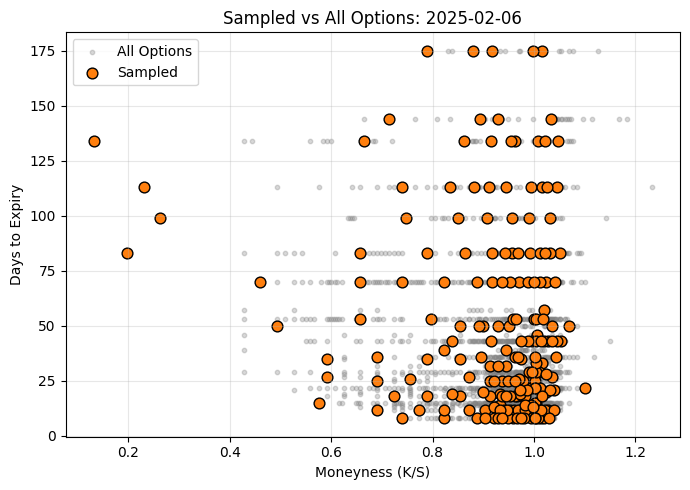


Partition: date=2024-03-04
Sampled shape: (200, 7) Full shape: (2297, 7)
         date  strike         T  close option_type            S        r
0  2024-03-04  5280.0  0.021918   1.30        call  5130.950195  0.05223
1  2024-03-04  4850.0  0.076712   8.00         put  5130.950195  0.05223
2  2024-03-04  4600.0  0.298630  24.33         put  5130.950195  0.05223
3  2024-03-04  5700.0  0.317808  10.31        call  5130.950195  0.05223
4  2024-03-04  3700.0  0.106849   1.05         put  5130.950195  0.05223


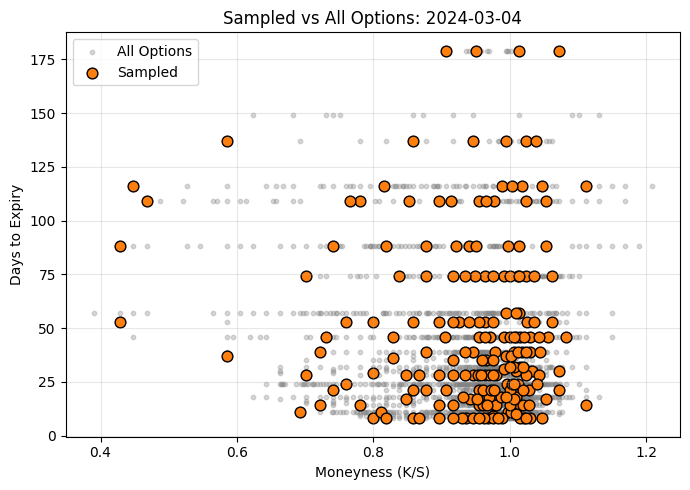


Partition: date=2024-09-25
Sampled shape: (200, 7) Full shape: (1948, 7)
         date  strike         T  close option_type            S        r
0  2024-09-25  5650.0  0.115068  73.65         put  5722.259766  0.04487
1  2024-09-25  4500.0  0.095890   2.69         put  5722.259766  0.04487
2  2024-09-25  5950.0  0.235616  69.95        call  5722.259766  0.04487
3  2024-09-25  5895.0  0.098630  22.30        call  5722.259766  0.04487
4  2024-09-25  5430.0  0.052055   8.44         put  5722.259766  0.04487


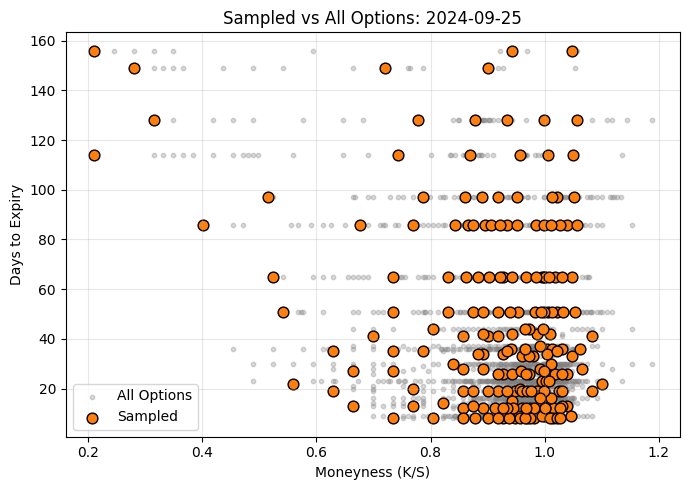


Partition: date=2024-05-01
Sampled shape: (200, 7) Full shape: (2318, 7)
         date  strike         T  close option_type            S       r
0  2024-05-01  4775.0  0.052055   9.20         put  5018.390137  0.0525
1  2024-05-01  5175.0  0.073973  24.10        call  5018.390137  0.0525
2  2024-05-01  4725.0  0.293151  53.91         put  5018.390137  0.0525
3  2024-05-01  5350.0  0.331507  66.90        call  5018.390137  0.0525
4  2024-05-01  5030.0  0.043836  60.90        call  5018.390137  0.0525


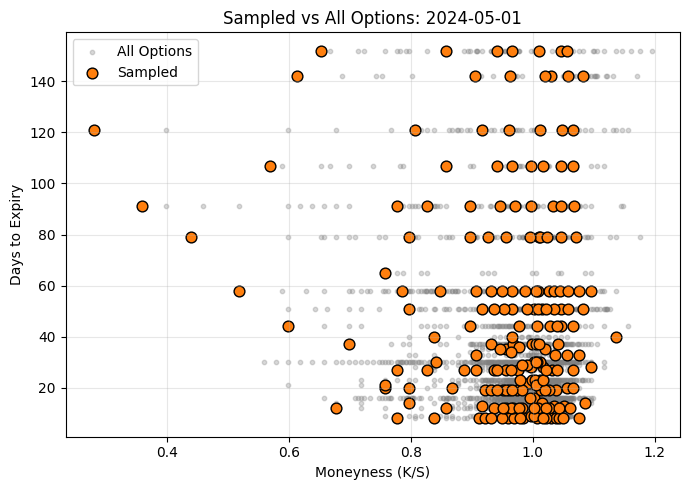


Partition: date=2024-06-14
Sampled shape: (200, 7) Full shape: (2085, 7)
         date  strike         T  close option_type            S       r
0  2024-06-14  4980.0  0.115068   9.02         put  5431.600098  0.0524
1  2024-06-14  5450.0  0.065753  58.15         put  5431.600098  0.0524
2  2024-06-14  5400.0  0.268493  98.90         put  5431.600098  0.0524
3  2024-06-14  4290.0  0.295890   9.70         put  5431.600098  0.0524
4  2024-06-14  4500.0  0.027397   0.30         put  5431.600098  0.0524


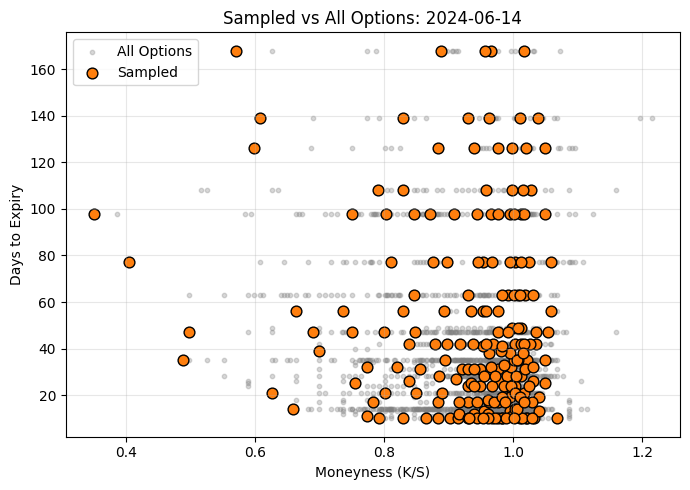


Partition: date=2024-01-16
Sampled shape: (200, 7) Full shape: (2195, 7)
         date  strike         T  close option_type           S        r
0  2024-01-16  2450.0  0.161644   0.40         put  4765.97998  0.05203
1  2024-01-16  4735.0  0.084932  47.29         put  4765.97998  0.05203
2  2024-01-16  4450.0  0.073973   6.30         put  4765.97998  0.05203
3  2024-01-16  4950.0  0.073973   5.73        call  4765.97998  0.05203
4  2024-01-16  4575.0  0.334247  69.35         put  4765.97998  0.05203


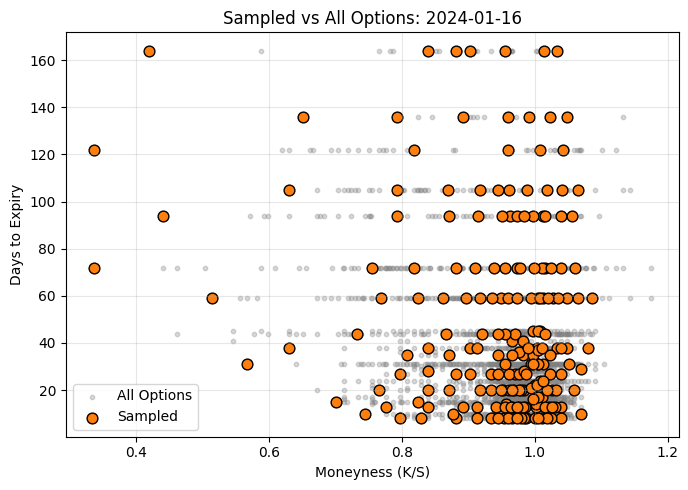

In [50]:
# Read sampled options data and visualize against full options universe

import polars as pl
import os
import random
import matplotlib.pyplot as plt

SAMPLED_PARQUET_DIR = r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_sampled_hybrid_parquet"
PRE_FILTERED_PARQUET_DIR = r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_pre_filtered_parquet"

# Gather all available pre-filtered parquet files (look for '0.parquet')
pre_filtered_files = []
for root, dirs, files in os.walk(PRE_FILTERED_PARQUET_DIR):
    for file in files:
        if file == '0.parquet':
            pre_filtered_files.append(os.path.join(root, file))

if not pre_filtered_files:
    raise FileNotFoundError(f"No '0.parquet' files found in {PRE_FILTERED_PARQUET_DIR}")

# Load all pre-filtered data (full options universe)
df_all = pl.concat([pl.read_parquet(f) for f in pre_filtered_files]).to_pandas()

# List all date partitions
partitions = [d for d in os.listdir(SAMPLED_PARQUET_DIR) if os.path.isdir(os.path.join(SAMPLED_PARQUET_DIR, d))]
partitions.sort()
sampled_partitions = random.sample(partitions, min(10, len(partitions)))

print("Sampled partitions:", sampled_partitions)

for part in sampled_partitions:
    # Extract date from partition name (assumes format date=YYYY-MM-DD)
    date_str = part.split('=')[1] if '=' in part else part
    part_dir = os.path.join(SAMPLED_PARQUET_DIR, part)
    parquet_files = [os.path.join(part_dir, f) for f in os.listdir(part_dir) if f == '0.parquet']
    if not parquet_files:
        print(f"No '0.parquet' file found in {part_dir}")
        continue
    df_sampled = pl.read_parquet(parquet_files).to_pandas()
    df_full = df_all[df_all['date'].astype(str) == date_str]
    print(f"\nPartition: {part}")
    print("Sampled shape:", df_sampled.shape, "Full shape:", df_full.shape)
    print(df_sampled.head(5))
    # Visualization: overlay sampled and full data
    if all(col in df_sampled.columns for col in ['strike', 'S', 'T']) and all(col in df_full.columns for col in ['strike', 'S', 'T']):
        moneyness_full = df_full['strike'] / df_full['S']
        expiry_full = df_full['T'] * 365
        moneyness_sampled = df_sampled['strike'] / df_sampled['S']
        expiry_sampled = df_sampled['T'] * 365
        plt.figure(figsize=(7, 5))
        plt.scatter(moneyness_full, expiry_full, s=10, c='gray', alpha=0.3, label='All Options')
        plt.scatter(moneyness_sampled, expiry_sampled, s=60, c='tab:orange', edgecolor='black', marker='o', label='Sampled')
        plt.xlabel('Moneyness (K/S)')
        plt.ylabel('Days to Expiry')
        plt.title(f"Sampled vs All Options: {date_str}")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()
    else:
        print("Required columns for visualization not found in this partition.")

In [52]:
import numpy as np
import polars as pl
from pathlib import Path

# Paths (adjust if needed)
SAMPLED_DIR = Path(r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_sampled_hybrid_parquet")

# 1) Load all sampled partitions into a single pandas DataFrame
df_sampled_all = (
    pl.scan_parquet(f"{SAMPLED_DIR}/date=*/*.parquet")
      .collect()
      .to_pandas()
)

# 2) Sanity‐check required columns
required_cols = ['date', 'strike', 'T', 'close', 'option_type', 'S', 'r']
missing = [c for c in required_cols if c not in df_sampled_all.columns]
if missing:
    raise ValueError(f"Missing required cols in sampled data: {missing}")

# 3) Basic emptiness & date‐count checks
if df_sampled_all.empty:
    raise ValueError("No sampled data found!")
unique_dates = df_sampled_all['date'].unique()
print(f"[Pre-Check] Dates covered: {len(unique_dates)}  (e.g. {unique_dates[:3]})")

# 4) Inspect the very first date's slice
first_date = unique_dates[0]
df0 = df_sampled_all[df_sampled_all['date'] == first_date]
print(f"\n[Pre-Check] Date = {first_date} → {len(df0)} rows")

for col in required_cols[1:]:  # skip 'date'
    ser     = df0[col]
    dtype   = getattr(ser, 'dtype', type(ser.iloc[0]))
    n_nan   = ser.isna().sum()
    print(f"  • {col:12s} dtype={dtype},  rows={ser.shape[0]},  NaNs={n_nan}")

# 5) Convert to numpy and check
strikes = np.asarray(df0['strike'], dtype=float)
T       = np.asarray(df0['T'], dtype=float)
prices  = np.asarray(df0['close'], dtype=float)
flags   = np.where(df0['option_type']=='call','c','p')
r_arr   = np.full_like(strikes, df0['r'].iloc[0], dtype=float)
q_arr   = np.zeros_like(strikes, dtype=float)

print("\n[Pre-Check] NumPy arrays:")
for name, arr in [
    ('strikes', strikes), ('T', T), ('prices', prices),
    ('flags', flags), ('r_arr', r_arr), ('q_arr', q_arr)
]:
    arr = np.asarray(arr)
    print(f"  • {name:8s} shape={arr.shape}, dtype={arr.dtype}", end='')
    if np.issubdtype(arr.dtype, np.number):
        print(f", NaNs={np.isnan(arr).sum()}")
    else:
        print()

# 6) Warn on degenerate arrays
for name, arr in [('strikes', strikes), ('T', T), ('prices', prices)]:
    if arr.size == 0:
        print(f"  [Warning] {name} is empty!")
    elif np.all(np.isnan(arr)):
        print(f"  [Warning] {name} all NaN!")
    elif np.all(arr == 0):
        print(f"  [Warning] {name} all zero!")

print("\n[Pre-Check] Completed successfully – ready for calibration.")


[Pre-Check] Dates covered: 367  (e.g. ['2024-01-02' '2024-01-03' '2024-01-04'])

[Pre-Check] Date = 2024-01-02 → 200 rows
  • strike       dtype=float64,  rows=200,  NaNs=0
  • T            dtype=float64,  rows=200,  NaNs=0
  • close        dtype=float64,  rows=200,  NaNs=0
  • option_type  dtype=object,  rows=200,  NaNs=0
  • S            dtype=float64,  rows=200,  NaNs=0
  • r            dtype=float64,  rows=200,  NaNs=0

[Pre-Check] NumPy arrays:
  • strikes  shape=(200,), dtype=float64, NaNs=0
  • T        shape=(200,), dtype=float64, NaNs=0
  • prices   shape=(200,), dtype=float64, NaNs=0
  • flags    shape=(200,), dtype=<U1
  • r_arr    shape=(200,), dtype=float64, NaNs=0
  • q_arr    shape=(200,), dtype=float64, NaNs=0

[Pre-Check] Completed successfully – ready for calibration.


In [11]:
# Calibration over a date range with full worker logic, now with LM progress logs returned

import os
import time
from datetime import datetime
from pathlib import Path

import polars as pl
import numpy as np
from joblib import Parallel, delayed

from Heston_COS_METHOD import heston_cosine_method
from Levenberg_Marquardt import levenberg_Marquardt
from Heston_Calibration_Class import Data_Class
from py_vollib_vectorized import vectorized_implied_volatility as calculate_iv

# === CONFIG ===
SAMPLED_DIR = Path(r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_sampled_hybrid_parquet")
CALIB_DIR   = Path(r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_calibrated_parquet")
CALIB_DIR.mkdir(parents=True, exist_ok=True)

# === SELECT DATE WINDOW ===
start_date = datetime(2024, 1, 2).date()
end_date   = datetime(2024, 1, 16).date()

def calibrate_one_date(part_dir: Path):
    date = part_dir.name.split('=')[1]
    print(f"→ Starting calibration for {date}")

    # Read that date's Parquet(s)
    dfs = [pl.read_parquet(f) for f in part_dir.glob("*.parquet")]
    df_pl = pl.concat(dfs)

    # Extract arrays
    S       = float(df_pl["S"][0])
    strikes = df_pl["strike"].to_numpy()
    T       = df_pl["T"].to_numpy()
    prices  = df_pl["close"].to_numpy()
    flags   = np.where(df_pl["option_type"].to_numpy() == "call", "c", "p")
    r       = float(df_pl["r"][0])
    q       = 0.0
    r_arr   = np.full_like(strikes, r, dtype=float)
    q_arr   = np.full_like(strikes, q, dtype=float)

    # Build calibration container
    data = Data_Class()
    data.S             = S
    data.K             = strikes
    data.T             = T
    data.r             = r_arr
    data.q             = q_arr
    data.market_prices = prices
    data.flag          = flags
    data.calculate_implied_vol()
    market_vol = data.market_vol

    # Calibration parameters
    initial_guess       = np.array([0.04, 0.50, -0.70, 1.0, 0.04]).reshape(5,1)
    N, L                = 100, 10
    I, w                = 500, 1e-3
    precision           = 0.01
    params_to_calibrate = ['vbar','sigma','rho','kappa','v0']
    accel_mag, min_acc  = 1, 1e-3

    # Run Levenberg–Marquardt and collect logs
    calib_params, acc, rej, RMSE, lm_logs = levenberg_Marquardt(
        data, initial_guess, I, w, N, L, precision,
        params_to_calibrate, accel_mag, min_acc, return_logs=True
    )

    # Price via Heston COS
    h_prices = heston_cosine_method(
        data.S, strikes, T, N, L, r_arr, q_arr,
        calib_params[0,0], calib_params[4,0],
        calib_params[1,0], calib_params[2,0],
        calib_params[3,0], flags
    )

    # Implied vol of Heston prices
    calib_iv = (
        calculate_iv(
            h_prices, S, strikes, T, r_arr, flags, q_arr,
            model='black_scholes_merton', return_as='numpy'
        ) * 100
    ).ravel()

    # Assemble output DataFrame
    out = pl.DataFrame({
        "date": [date]*len(strikes),
        "strike": strikes,
        "T": T,
        "close": prices,
        "option_type": df_pl["option_type"].to_numpy(),
        "S": [S]*len(strikes),
        "r": [r]*len(strikes),
        "q": [q]*len(strikes),
        "market_vol": market_vol,
        "calib_iv": calib_iv,
        "calib_vbar": float(calib_params[0,0]),
        "calib_sigma": float(calib_params[1,0]),
        "calib_rho": float(calib_params[2,0]),
        "calib_kappa": float(calib_params[3,0]),
        "calib_v0": float(calib_params[4,0]),
        "calib_rmse": float(RMSE[-1]) if len(RMSE)>0 else np.nan,
        "calib_acc": int(acc),
        "calib_rej": int(rej),
    })

    # Write partitioned by date
    out_dir = CALIB_DIR / f"date={date}"
    out_dir.mkdir(parents=True, exist_ok=True)
    out.write_parquet(out_dir/"part-0.parquet", compression="snappy")

    print(f"✓ Finished calibration for {date}")
    return date, lm_logs

# === MAIN EXECUTION ===
all_date_dirs = sorted(SAMPLED_DIR.glob("date=*"))
# Filter to your desired window
date_dirs = []
for d in all_date_dirs:
    dstr = d.name.split('=')[1]
    ddate = datetime.strptime(dstr, "%Y-%m-%d").date()
    if start_date <= ddate <= end_date:
        date_dirs.append(d)

print(f"Running calibration on {len(date_dirs)} days from {start_date} to {end_date}")

start = time.time()
processed = Parallel(n_jobs=max(1, os.cpu_count() - 2), verbose=5)(
    delayed(calibrate_one_date)(d) for d in date_dirs
)
total_min = (time.time() - start) / 60
print(f"\n✅ Calibrated {len(processed)} dates in {total_min:.1f} minutes")

# Print LM logs for each date
for date, lm_logs in processed:
    print(f"\n--- LM Progress for {date} ---")
    for line in lm_logs:
        print(line)

Running calibration on 10 days from 2024-01-02 to 2024-01-16


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done   4 out of  10 | elapsed:  1.6min remaining:  2.3min
[Parallel(n_jobs=14)]: Done   7 out of  10 | elapsed:  1.6min remaining:   40.8s



✅ Calibrated 10 dates in 1.6 minutes

--- LM Progress for 2024-01-02 ---
Iteration 0: RMSE=7.9399, params=[0.039485779938416954, 0.5002082100023136, -0.6997495926096885, 1.000017163290036, 0.038829628838378406]
Iteration 10: RMSE=7.6277, params=[0.04301292891172921, 0.5563469657117888, -0.6667704178148841, 1.1871697579424785, 0.037516385818736474]
Iteration 20: RMSE=7.3064, params=[0.04363162299102338, 0.6316931765928384, -0.6273155845389866, 1.7045764152975882, 0.036254606776270695]
Iteration 30: RMSE=6.9989, params=[0.043656364033513154, 0.7080515413195604, -0.5950644133807786, 2.198365690061244, 0.03504310365314426]
Iteration 40: RMSE=6.7060, params=[0.04347561040108245, 0.7843989470397391, -0.569077371393075, 2.6645224360412376, 0.033879824395140784]
Iteration 50: RMSE=6.4278, params=[0.04321116874469544, 0.8601424229201136, -0.5482331272207457, 3.1032863330084766, 0.032763557533656826]
Iteration 60: RMSE=6.1641, params=[0.04291334260407933, 0.9349411581788029, -0.5315186603378226

[Parallel(n_jobs=14)]: Done  10 out of  10 | elapsed:  1.6min finished


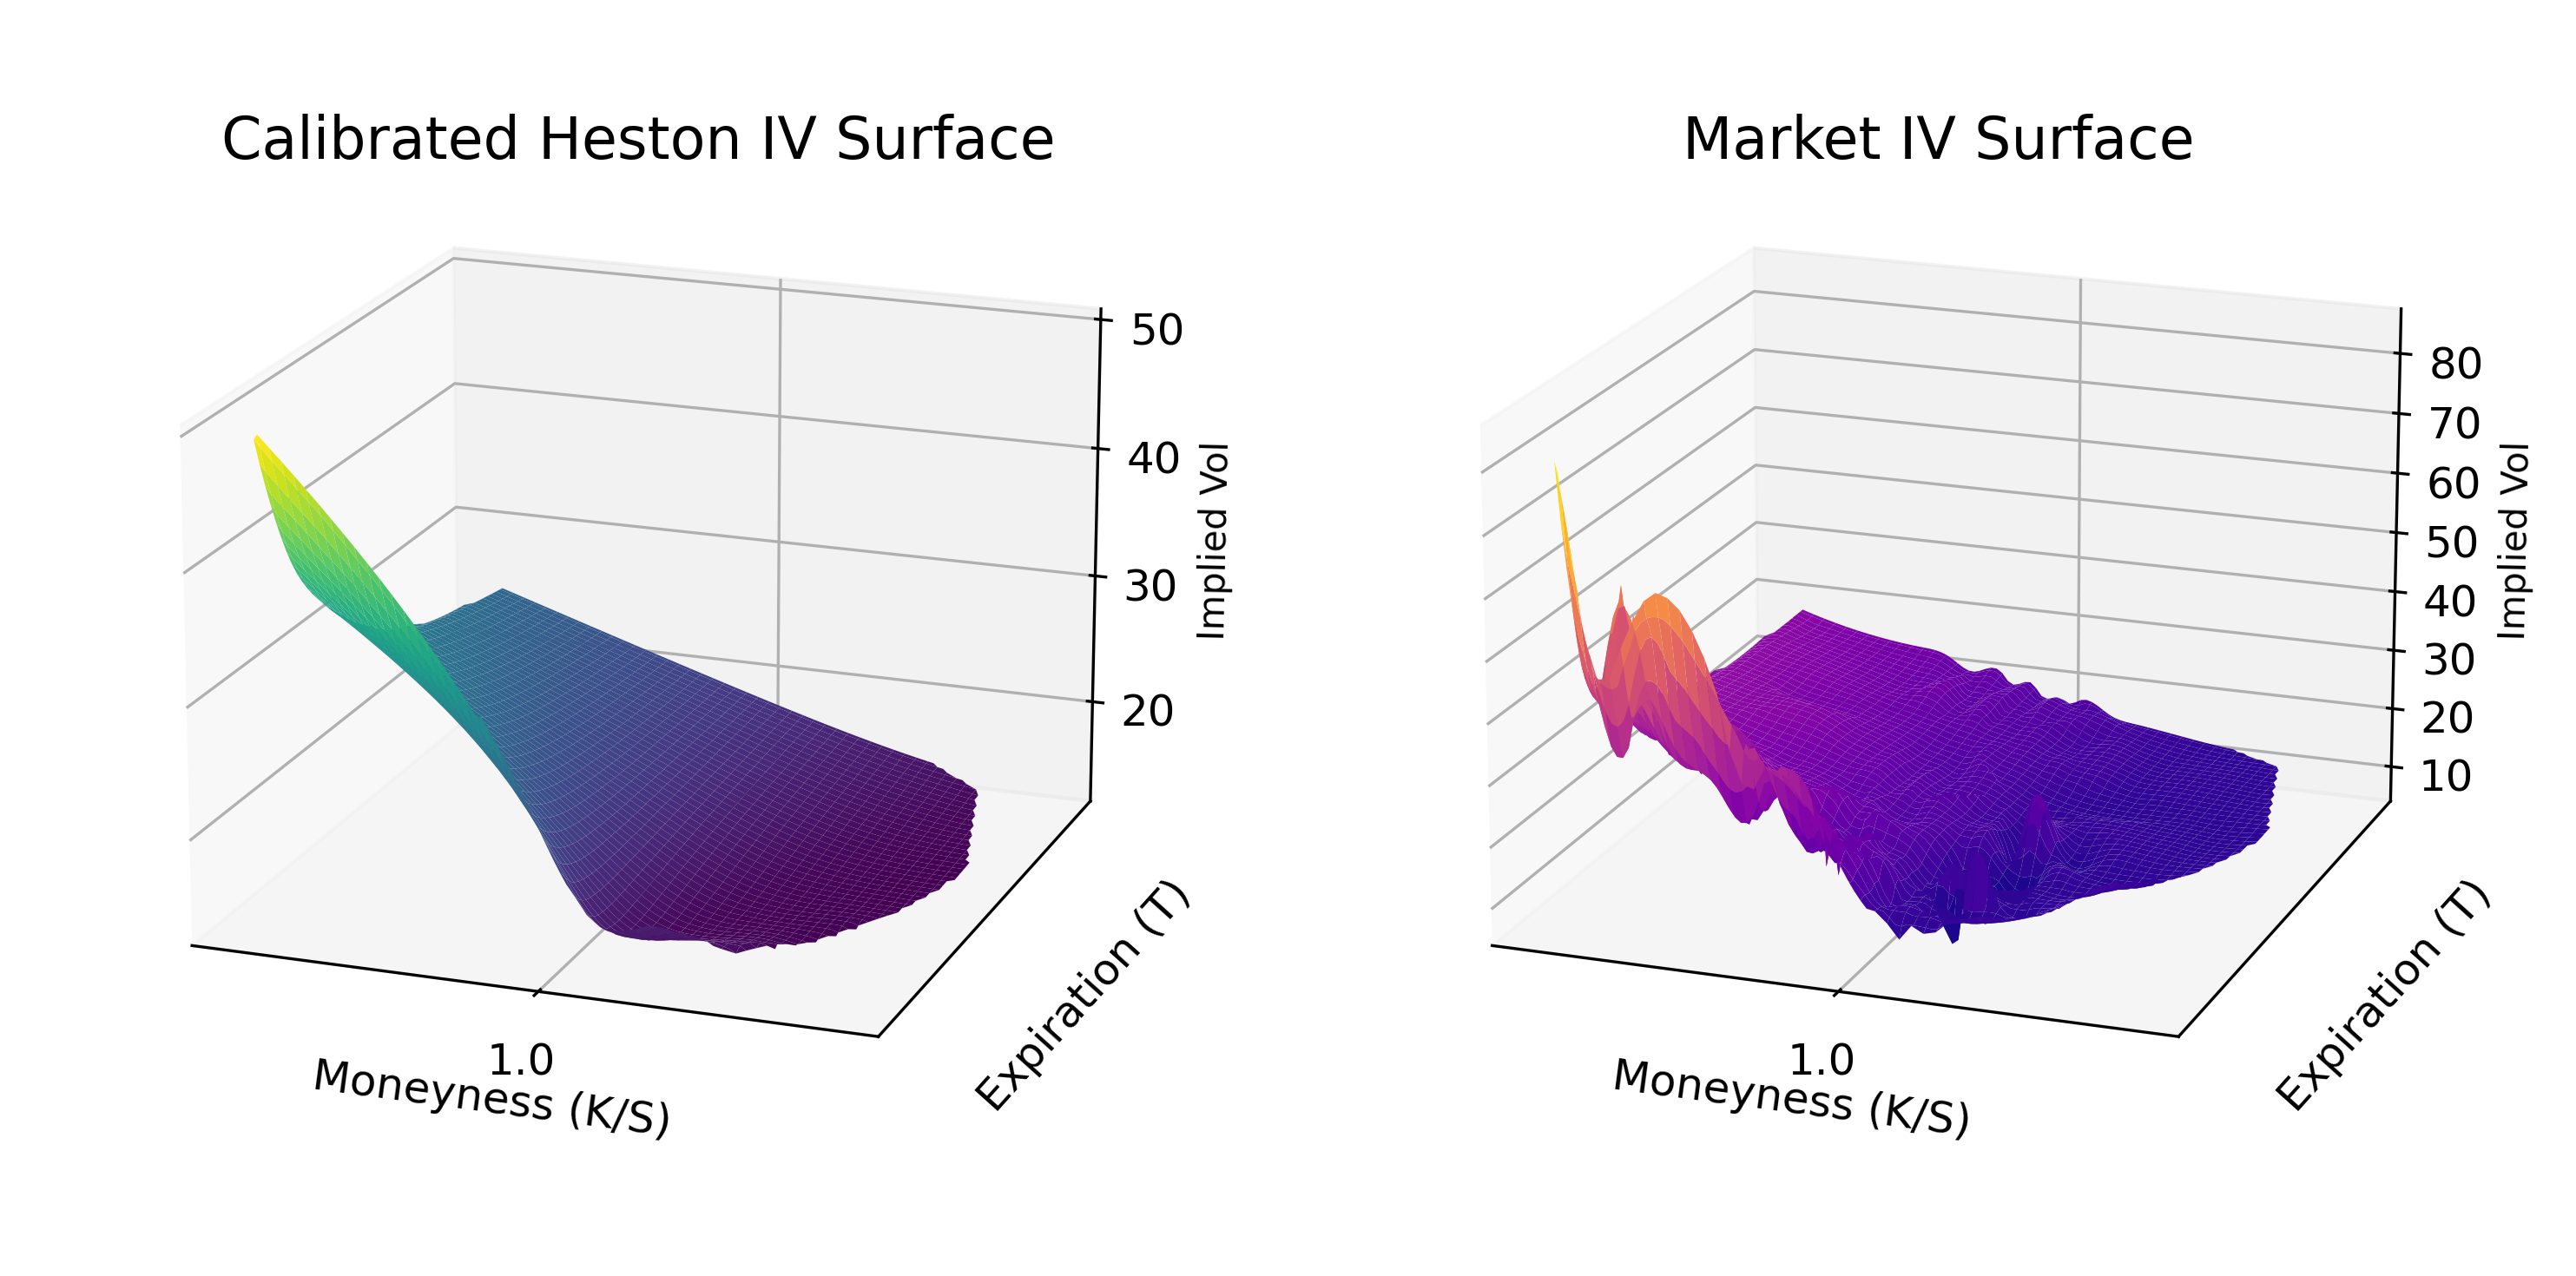

In [ ]:
# 1) After your LM call, use the *filtered* Data_calib attributes:
K_cal  = Data_calib.K
T_cal  = Data_calib.T
r_cal  = Data_calib.r
q_cal  = Data_calib.q
flag_cal = Data_calib.flag

# 2) Recompute model prices on exactly those same points:
heston_prices = heston_cosine_method(
    Data_calib.S,
    K_cal,
    T_cal,
    N, L,
    r_cal,
    q_cal,
    calib_params[0,0],  # vbar
    calib_params[4,0],  # v0
    calib_params[1,0],  # sigma
    calib_params[2,0],  # rho
    calib_params[3,0],  # kappa
    flag_cal
)

# 3) Compute implied vols, flatten to 1D:
from py_vollib_vectorized import vectorized_implied_volatility as calculate_iv
calibrated_iv = calculate_iv(
    heston_prices,
    Data_calib.S,
    K_cal,
    T_cal,
    r_cal,
    flag_cal,
    q_cal,
    model='black_scholes_merton',
    return_as='numpy'
) * 100
calibrated_iv = calibrated_iv.ravel()  # make it a (N,) array

# 4) Now this will line up:
assert calibrated_iv.shape == K_cal.shape

# 5) And finally call the plot routine:
Data_calib.plot_save_surface(calibrated_iv, date_today='2024-01-02')

In [17]:
from joblib import Parallel, delayed
import polars as pl
import numpy as np
from pathlib import Path
from Heston_Calibration_Class import Data_Class
from py_vollib_vectorized import vectorized_implied_volatility as calculate_iv
import os

def plot_surface_for_date(date, calib_dir, out_dir):
    try:
        day_dir = calib_dir / f"date={date}"
        if not day_dir.exists():
            print(f"[Surface] Skipping {date}: directory not found.")
            return date, False
        files = list(day_dir.glob("*.parquet"))
        if not files:
            print(f"[Surface] Skipping {date}: no parquet files found.")
            return date, False
        df_day = pl.concat([pl.read_parquet(f) for f in files]).to_pandas()
        if df_day.empty:
            print(f"[Surface] Skipping {date}: DataFrame empty.")
            return date, False
        data = Data_Class()
        data.S = float(df_day["S"].iloc[0])
        data.K = df_day["strike"].values.astype(float)
        data.T = df_day["T"].values.astype(float)
        data.r = np.full_like(data.K, float(df_day["r"].iloc[0]), dtype=float)
        data.q = np.zeros_like(data.K, dtype=float)
        data.market_prices = df_day["close"].values.astype(float)
        data.flag = np.where(df_day["option_type"] == "call", "c", "p")
        data.calculate_implied_vol()
        calib_iv = df_day["calib_iv"].values.astype(float)
        # Create output directory if needed
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f"{date}.png"
        data.plot_save_surface(calibrated_iv=calib_iv, date_today=date, save_path=str(out_path))
        print(f"[Surface] Plotted and saved for {date} at {out_path}")
        return date, True
    except Exception as e:
        print(f"[Surface] Error for {date}: {e}")
        return date, False

# --- Configuration: date range ---
CALIB_PARQUET_DIR = Path(r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_calibrated_parquet")
SURFACE_PNG_DIR = Path(r"C:\Users\kevin\OneDrive\Desktop\Draco\data\spxw_surface_png")
all_dirs = [d for d in CALIB_PARQUET_DIR.glob("date=*") if d.is_dir()]
all_dates = sorted([d.name.split("=")[1] for d in all_dirs])

# Choose your date range here:
start_date = "2024-01-02"
end_date   = "2024-01-16"
sel_dates = [d for d in all_dates if start_date <= d <= end_date]

print(f"Plotting surfaces for {len(sel_dates)} dates from {start_date} to {end_date}")

results = Parallel(n_jobs=os.cpu_count() or 1, verbose=5)(
    delayed(plot_surface_for_date)(date, CALIB_PARQUET_DIR, SURFACE_PNG_DIR) for date in sel_dates
)

n_success = sum(1 for _, ok in results if ok)
print(f"\n[Surface] Completed {n_success}/{len(sel_dates)} surfaces.")

Plotting surfaces for 10 dates from 2024-01-02 to 2024-01-16

[Surface] Completed 0/10 surfaces.


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done   6 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=16)]: Done  10 out of  10 | elapsed:    0.0s finished
